In [1]:
# plot seasonality of storm-induced anoamlies relative to derivations from cliamtology + number of storms per month
# Fig. 5 in paper (bottom panels)
# Fig. S3 in paper

In [2]:
import os
from tqdm import tqdm
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from netCDF4 import Dataset, MFDataset
import numba as nb
import time as timing
from numba import njit 
from math import sin, cos, sqrt, atan2, radians
from geopy.distance import distance
import seawater as sw
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)

In [3]:
#---
# CHOOSE YEARS to plot
#---

years = np.arange(1997,2018+1,1) 

#---
# SAVEPATH
#---

#---
# where to save plots?
#---
savepath     = '/global/cfs/cdirs/m4003/cnissen/Plots/CESM_storms/composites_1997_2018_subtract_clim_first/'+\
                    'storm_anomalies_vs_deviations_from_clim/FIXED_DUPLICATES_v2/'
# check existence of paths
if not os.path.exists(savepath):
    print ('Created '+savepath)
    os.makedirs(savepath)
    
savepath2     = savepath+'eps/'
# check existence of paths
if not os.path.exists(savepath2):
    print ('Created '+savepath2)
    os.makedirs(savepath2)
    
dpicnt = 150
save_plots    = True
display_plots = True


In [4]:
#---
# FUNCTION 
#---

def get_distance_to_storm_center(lat2,lon2,aux_lat,aux_lon):
                
    # create list of locations within 1000km of the storm
    points_data = []
    for pp in range(0,lat2.shape[0]):
        aux = (lat2[pp],lon2[pp])
        points_data.append(aux)
        del aux

    #print(len(points_data))
    # for each of these points get the distance to the storm center in km -> get distance in x-dir and y-dir
    points_distance_x = np.zeros(len(points_data)) # distance in longitudinal direction, i.e., use latitude of storm (aux_lat)
    points_distance_y = np.zeros(len(points_data)) # distance in latitudinal direction, i.e., use longitude of storm (aux_lon)
    for pp in range(0,len(points_data)): 
        # distance in longitudinal direction
        aux_point = (aux_lat,points_data[pp][1])
        points_distance_x[pp] = distance(point_storm, aux_point).km
       # print(aux_point,point_storm,points_distance_x[pp])
        # check sign: if lon grid cell is smaller (=further west) than lon of storm, define distance to be negative
        if points_data[pp][1]<aux_lon:
            points_distance_x[pp] = -1*points_distance_x[pp]
        elif (aux_lon<0) & (points_data[pp][1]>0): # lon_storm is east of dateline, but grid cell is west of dateline (grid cell is also further west in this case!)
            if (points_data[pp][1]-360)<aux_lon:
                points_distance_x[pp] = -1*points_distance_x[pp]
        del aux_point
        # distance in latitudinal direction
        aux_point = (points_data[pp][0],aux_lon)
        points_distance_y[pp] = distance(point_storm, aux_point).km
        # check sign: if lat grid cell is smaller (=further south) than lat of storm, define distance to be negative
        if points_data[pp][0]<aux_lat:
            points_distance_y[pp] = -1*points_distance_y[pp]
        del aux_point  
    return points_distance_x,points_distance_y,points_data
                    
    
def bin_points_as_distance_to_storm_center(counter,points_distance_x,points_distance_y,x_bins,y_bins,aux_data_anom,data_storm_mean,data_storm_std,data_storm_count):
    # data_storm_mean,data_storm_std,data_storm_count: initialized arrays, will be filled in this function and then returned
    
    # bin the points (account for where each point is relative to storm center)
    ind_x = np.digitize(points_distance_x,x_bins,right=False) # minimum is 1 (not zero!!)
    ind_y = np.digitize(points_distance_y,y_bins,right=False)
 #   print(np.min(ind_x),np.max(ind_x))
 #   print(np.min(ind_y),np.max(ind_y))
    # returned index satisfies: bins[i-1] <= x < bins[i]

   # print(aux_data_anom.shape)
    for xx in range(1,len(x_bins)+1): # start at 1 here -> see note above for ind_x
        for yy in range(1,len(x_bins)+1):
            index = np.where((ind_y==yy) & (ind_x==xx))[0]
            if len(index)>0:
                #if counter==6: 
                #    print(xx,yy,index.shape,aux_data_anom.shape)
                #if (counter==40) & (xx==11) & (yy==20):
                #    print(xx,yy,len(points_distance_x))
                #    print(index)
                #    print(index.shape,aux_data_anom.shape)
                # anomaly 2
                data_storm_mean[xx-1,yy-1]  = np.nanmean(aux_data_anom[index])
                data_storm_std[xx-1,yy-1]   = np.nanstd(aux_data_anom[index])
                data_storm_count[xx-1,yy-1] = index.shape[0]
            del index
    return data_storm_mean,data_storm_std,data_storm_count
    

In [5]:
#---
# LOAD COMPOSITES for totChl (low res/full, low res/emulator, high res)
#---

def get_median_ratio(data_storm_aux,data_dev_aux,month_storm_aux,ratio_median,ratio_median_monthly):
    
    # get the median ratio for each year
    counter = 0
    for ss in range(0,data_storm_aux.shape[0]):
        aux_field = 100*(np.nanmean(data_storm_aux[ss,:,:])/np.nanmean(data_dev_aux[ss,:,:]))
        if not np.isnan(aux_field):
            ratio_median[yy] = ratio_median[yy] + aux_field
            counter = counter+1
    ratio_median[yy] = np.divide(ratio_median[yy],counter)
    
    # get the median ratio for each year, EACH MONTH
    for mm in range(0,12):
        ind_mm = np.where(month_storm_aux==mm+1)[0]
        counter = 0
        for ss in ind_mm: 
            aux_field = 100*(np.nanmean(data_storm_aux[ss,:,:])/np.nanmean(data_dev_aux[ss,:,:]))
            if not np.isnan(aux_field):
                ratio_median_monthly[yy,mm] = ratio_median_monthly[yy,mm] + aux_field
                counter = counter+1
        ratio_median_monthly[yy,mm] = np.divide(ratio_median_monthly[yy,mm],counter)
        
    return ratio_median,ratio_median_monthly

def grow_arrays(yy,year_list,data_storm_aux,data_dev_aux,month_storm_aux,lat_storm_aux,lon_storm_aux,slp_avg_storm_aux,slp_min_storm_aux,\
                                                           data_storm,data_dev,month_storm,lat_storm,lon_storm,slp_avg_storm,slp_min_storm,year_storm): 
    if yy==0:
        data_storm  = data_storm_aux
        data_dev    = data_dev_aux
        month_storm = month_storm_aux
        lat_storm   = lat_storm_aux
        lon_storm   = lon_storm_aux
        slp_min_storm   = slp_min_storm_aux
        slp_avg_storm   = slp_avg_storm_aux
        year_storm = year_list[yy]*np.ones(data_storm_aux.shape[0])
    else:
        data_storm  = np.concatenate((data_storm,data_storm_aux))
        data_dev    = np.concatenate((data_dev,data_dev_aux))
        month_storm = np.concatenate((month_storm,month_storm_aux))
        lat_storm   = np.concatenate((lat_storm,lat_storm_aux))
        lon_storm   = np.concatenate((lon_storm,lon_storm_aux))
        slp_min_storm   = np.concatenate((slp_min_storm,slp_min_storm_aux))
        slp_avg_storm   = np.concatenate((slp_avg_storm,slp_avg_storm_aux))
        year_storm  = np.concatenate((year_storm,year_list[yy]*np.ones(data_storm_aux.shape[0])))
                
    return data_storm,data_dev,month_storm,lat_storm,lon_storm,slp_avg_storm,slp_min_storm,year_storm

def load_data(path1a,path1b,file1,file3,vari1a,vari1b): 
    # storm-induced anomaly
    ff  = xr.open_dataset(path1a+file1)
    data_storm_aux  = ff[vari1a+'_storm_anomaly4_mean'].values 
    month_storm_aux = ff['month_storm'].values  # at min. SLP
    day_storm_aux   = ff['day_storm'].values  # at min. SLP
    year_storm_aux  = ff['year_storm'].values  # at min. SLP
    lat_storm_aux   = ff['lat_storm'].values  # at min. SLP
    lon_storm_aux   = ff['lon_storm'].values  # at min. SLP
    slp_avg_storm_aux   = ff['avg_min_slp_storm'].values  # avg of all min SLP over all time steps of the storm's existence 
    slp_min_storm_aux   = ff['min_min_slp_storm'].values  # min. SLP over all time steps of the storm's existence 
    ff.close()
    data_storm_aux[data_storm_aux==0] = np.nan
    
    # deviations from climatology
    ff  = xr.open_dataset(path1b+file3)
    data_dev_aux = ff[vari1b+'_storm_anomaly4_mean'].values 
    ff.close()
    data_dev_aux[data_dev_aux==0] = np.nan
    
    return data_storm_aux,day_storm_aux,month_storm_aux,year_storm_aux,\
                lat_storm_aux,lon_storm_aux,data_dev_aux,slp_avg_storm_aux,slp_min_storm_aux
    

year_list = np.arange(1997,2018+1,1)

vari = 'totChl'
path1 = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/'+vari+'_anomalies/'
path2 = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/'+vari+'_emulator_anomalies/'
path3 = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/'+vari+'_hr_anomalies/'
    
# what's the median ratio between storm-induced anomalies and deviations from clim?
ratio_median            = np.zeros([len(year_list)]) 
ratio_median_monthly    = np.zeros([len(year_list),12])
ratio_median_em         = np.zeros([len(year_list)]) 
ratio_median_monthly_em = np.zeros([len(year_list),12])
ratio_median_hr         = np.zeros([len(year_list)]) 
ratio_median_monthly_hr = np.zeros([len(year_list),12])
# initilize variables (will be overwritten!)
#data_storm,data_dev,month_storm,lat_storm,lon_storm,slp_avg_storm,slp_min_storm,year_storm = [],[],[],[],[],[],[],[]
#data_storm_em,data_dev_em,month_storm_em,lat_storm_em,lon_storm_em,slp_avg_storm_em,slp_min_storm_em,year_storm_em = [],[],[],[],[],[],[],[]
#data_storm_hr,data_dev_hr,month_storm_hr,lat_storm_hr,lon_storm_hr,slp_avg_storm_hr,slp_min_storm_hr,year_storm_hr = [],[],[],[],[],[],[],[]

#----
# LOW RES, FULL FIELD
#----
    
# storm-induced anomaly
file1 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_totChl_'+\
                str(year_list[0])+'_'+str(year_list[-1])+'_subtract_clim_first.nc'
# deviations from climatology
file3 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_totChl_'+\
                str(year_list[0])+'_'+str(year_list[-1])+'_subtract_clim_only.nc'

# load data
data_storm,day_storm,month_storm,year_storm,lat_storm,lon_storm,\
            data_dev,slp_avg_storm,slp_min_storm = load_data(path1,path1,file1,file3,vari,vari)
    
## get median ratio for each year (& month) individually (--> look at variability of median across years/months!)
#ratio_median,ratio_median_monthly = get_median_ratio(data_storm_aux,data_dev_aux,month_storm_aux,\
#                                                         ratio_median,ratio_median_monthly)
        
#----
# LOW RES, EMULATOR
#----
    
# storm-induced anomaly
#file1 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_totChl_emulator_'+\
#            str(year_list[0])+'_'+str(year_list[-1])+'_subtract_clim_first.nc'
file1 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_totChl_emulator_'+\
            str(year_list[0])+'_'+str(year_list[-1])+'_subtract_clim_first.nc' # in TEST folder, this is the file using the full-field clim
# deviations from climatology
file3 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_totChl_'+\
                str(year_list[0])+'_'+str(year_list[-1])+'_subtract_clim_only.nc' # uses full-field clim

# storm-induced anomaly


# load data
data_storm_em,day_storm_em,month_storm_em,year_storm_em,lat_storm_em,lon_storm_em,\
            data_dev_em,slp_avg_storm_em,slp_min_storm_em = load_data(path2+'TEST/',path1,file1,file3,vari+'_emulator',vari)
    
## get median ratio for each year (& month) individually (--> look at variability of median across years/months!)
#ratio_median_em,ratio_median_monthly_em = get_median_ratio(data_storm_aux,data_dev_aux,month_storm_aux,\
#                                                         ratio_median_em,ratio_median_monthly_em)
    

plot_hr = True
if plot_hr:
    #----
    # HIGH RES, FULL FIELD
    #----

    # storm-induced anomaly
    file1 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_totChl_hr_'+\
                str(year_list[0])+'_'+str(year_list[-1])+'_subtract_clim_first.nc'
    # deviations from climatology
    file3 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_totChl_hr_'+\
                str(year_list[0])+'_'+str(year_list[-1])+'_subtract_clim_only.nc'

    # load data
    data_storm_hr,day_storm_hr,month_storm_hr,year_storm_hr,lat_storm_hr,lon_storm_hr,\
                data_dev_hr,slp_avg_storm_hr,slp_min_storm_hr = load_data(path3,path3,file1,file3,vari,vari)

    ## get median ratio for each year (& month) individually (--> look at variability of median across years/months!)
    #ratio_median_hr,ratio_median_monthly_hr = get_median_ratio(data_storm_aux,data_dev_aux,month_storm_aux,\
    #                                                     ratio_median_hr,ratio_median_monthly_hr)

    print(data_storm_hr.shape,data_dev_hr.shape)
    
print(data_storm.shape,data_dev.shape)
print(data_storm_em.shape,data_dev_em.shape)



#----
# make sure that the same storms are considered in LOW RES and HIGH RES
#----

data_aux_mean = np.nanmean(np.nanmean(data_storm,axis=2),axis=1)
ind_no_NaN = np.where(~np.isnan(data_aux_mean))[0]
ind_no_NaN_lr = np.copy(ind_no_NaN) # for wind speeds further down

data_storm     = data_storm[ind_no_NaN,:,:]
data_storm_em  = data_storm_em[ind_no_NaN,:,:]
if plot_hr:
    data_storm_hr  = data_storm_hr[ind_no_NaN,:,:]
data_dev     = data_dev[ind_no_NaN,:,:]
data_dev_em  = data_dev_em[ind_no_NaN,:,:]
if plot_hr:
    data_dev_hr  = data_dev_hr[ind_no_NaN,:,:]

month_storm = month_storm[ind_no_NaN]
year_storm  = year_storm[ind_no_NaN]
lat_storm   = lat_storm[ind_no_NaN]
lon_storm   = lon_storm[ind_no_NaN]
slp_avg_storm = slp_avg_storm[ind_no_NaN]
slp_min_storm = slp_min_storm[ind_no_NaN]

if plot_hr:
    month_storm_hr = month_storm_hr[ind_no_NaN]
    year_storm_hr  = year_storm_hr[ind_no_NaN]
    lat_storm_hr   = lat_storm_hr[ind_no_NaN]
    lon_storm_hr   = lon_storm_hr[ind_no_NaN]
    slp_avg_storm_hr = slp_avg_storm_hr[ind_no_NaN]
    slp_min_storm_hr = slp_min_storm_hr[ind_no_NaN]

month_storm_em = month_storm_em[ind_no_NaN]
year_storm_em  = year_storm_em[ind_no_NaN]
lat_storm_em   = lat_storm_em[ind_no_NaN]
lon_storm_em   = lon_storm_em[ind_no_NaN]
slp_avg_storm_em = slp_avg_storm_em[ind_no_NaN]
slp_min_storm_em = slp_min_storm_em[ind_no_NaN]

print('data_storm_em.shape',data_storm_em.shape)
if plot_hr:
    print('data_storm_hr.shape',data_storm_hr.shape)
print('data_storm.shape',data_storm.shape)


(9615, 21, 21) (9615, 21, 21)
(9615, 21, 21) (9615, 21, 21)
(9615, 21, 21) (9615, 21, 21)
data_storm_em.shape (9554, 21, 21)
data_storm_hr.shape (9554, 21, 21)
data_storm.shape (9554, 21, 21)


/tmp/ipykernel_54578/2382663562.py:171: RuntimeWarning: Mean of empty slice
  data_aux_mean = np.nanmean(np.nanmean(data_storm,axis=2),axis=1)


perc1,perc2 10 90


/tmp/ipykernel_54578/853615042.py:32: RuntimeWarning: Mean of empty slice
  ratio_em[tt] = 100*np.nanmean(data_storm_em[tt,:,:])/np.nanmean(data_dev_em[tt,:,:])


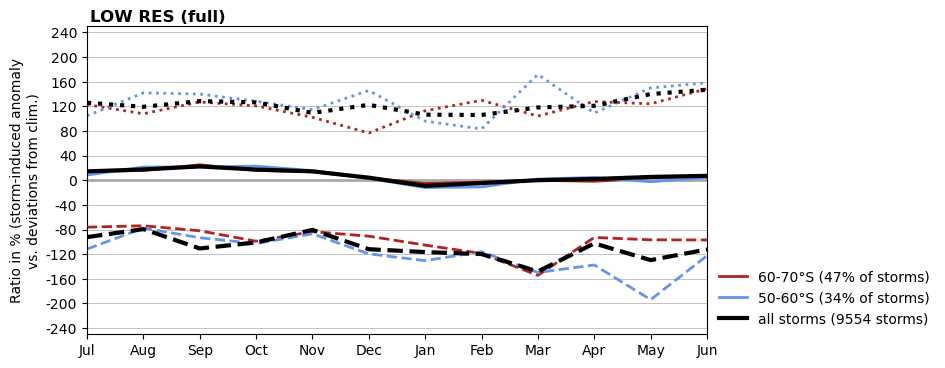

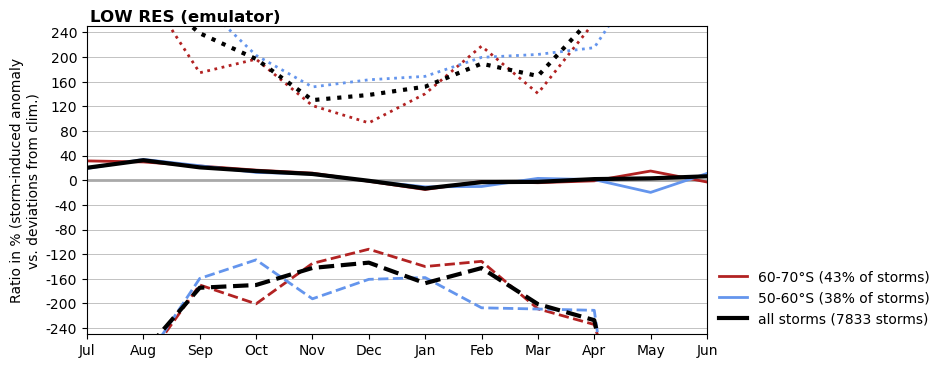

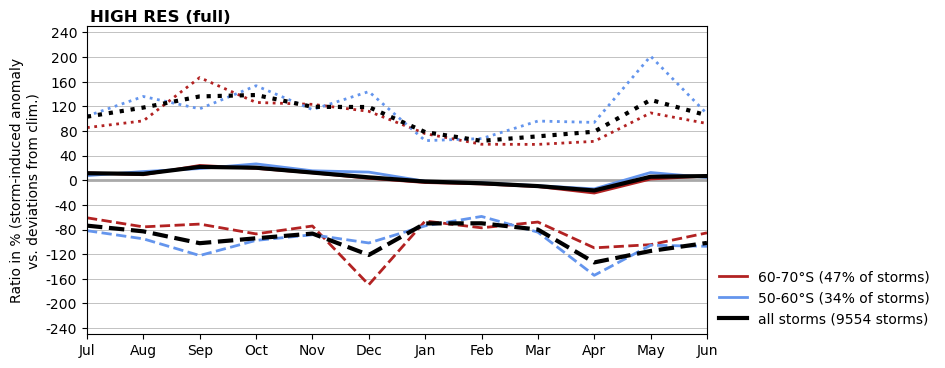

In [6]:
#---
# all percentiles together
#---

def reorder_months(data):
    data2 = np.copy(data)
    data2[0:6] = data[6:]
    data2[6:] = data[0:6]
    return data2

def reorder_months_daily(data):
    data2 = np.copy(data)
    data2[0:183] = data[182:]
    data2[182:] = data[0:183]
    return data2

perc1 = 10 #25
perc2 = 90 #75
print('perc1,perc2',perc1,perc2)

num_storms = data_storm.shape[0]

lat_bins = [-80,-70,-60,-50,-40] 

# get ratio for all storms
ratio    = np.zeros([num_storms])
if plot_hr:
    ratio_hr = np.zeros([num_storms])
ratio_em = np.zeros([num_storms])
for tt in range(0,num_storms):
    ratio[tt]    = 100*np.nanmean(data_storm[tt,:,:])/np.nanmean(data_dev[tt,:,:])
    ratio_em[tt] = 100*np.nanmean(data_storm_em[tt,:,:])/np.nanmean(data_dev_em[tt,:,:])
    if plot_hr:
        ratio_hr[tt] = 100*np.nanmean(data_storm_hr[tt,:,:])/np.nanmean(data_dev_hr[tt,:,:])

# get percentiles for each lat. band
all_perc    = np.zeros([3,12,len(lat_bins)]) # 25th perc/median/75th perc
if plot_hr:
    all_perc_hr = np.zeros([3,12,len(lat_bins)]) # 25th perc/median/75th perc
all_perc_em = np.zeros([3,12,len(lat_bins)]) # 25th perc/median/75th perc
all_mean    = np.zeros([12,len(lat_bins)]) 
if plot_hr:
    all_mean_hr = np.zeros([12,len(lat_bins)]) 
all_mean_em = np.zeros([12,len(lat_bins)]) 
num_storms_lat_bands = np.zeros([len(lat_bins)])
num_storms_lat_bands_em = np.zeros([len(lat_bins)])
if plot_hr:
    num_storms_lat_bands_hr = np.zeros([len(lat_bins)])
for dd in range(0,len(lat_bins)-1):
    for mm in range(0,12):
        ind_mm = np.where((month_storm==mm+1) & (lat_storm>=lat_bins[dd]) & (lat_storm<lat_bins[dd+1]))[0]
        # LOW RES (full)
        aux = ratio[ind_mm]
        ind_no_NaN = np.where(~np.isnan(aux))[0]
        num_storms_lat_bands[dd] = num_storms_lat_bands[dd]+ind_mm[ind_no_NaN].shape[0]
        all_perc[0,mm,dd] = np.percentile(aux[ind_no_NaN],perc1)
        all_perc[1,mm,dd] = np.percentile(aux[ind_no_NaN],50)
        all_perc[2,mm,dd] = np.percentile(aux[ind_no_NaN],perc2)
        all_mean[mm,dd] = np.mean(aux[ind_no_NaN])
        del aux,ind_no_NaN
        # LOW RES (emulator)
        aux = ratio_em[ind_mm]
        ind_no_NaN = np.where(~np.isnan(aux))[0]
        num_storms_lat_bands_em[dd] = num_storms_lat_bands_em[dd]+ind_mm[ind_no_NaN].shape[0]
        all_perc_em[0,mm,dd] = np.percentile(aux[ind_no_NaN],perc1)
        all_perc_em[1,mm,dd] = np.percentile(aux[ind_no_NaN],50)
        all_perc_em[2,mm,dd] = np.percentile(aux[ind_no_NaN],perc2)
        all_mean_em[mm,dd]   = np.mean(aux[ind_no_NaN])
        del aux,ind_no_NaN
        if plot_hr:
            # HIGH RES 
            aux = ratio_hr[ind_mm]
            ind_no_NaN = np.where(~np.isnan(aux))[0]
            num_storms_lat_bands_hr[dd] = num_storms_lat_bands_hr[dd]+ind_mm[ind_no_NaN].shape[0]
            all_perc_hr[0,mm,dd] = np.percentile(aux[ind_no_NaN],perc1)
            all_perc_hr[1,mm,dd] = np.percentile(aux[ind_no_NaN],50)
            all_perc_hr[2,mm,dd] = np.percentile(aux[ind_no_NaN],perc2)
            all_mean_hr[mm,dd]   = np.mean(aux[ind_no_NaN])
            del aux,ind_no_NaN
        
# all storms
num_storms_all = 0
num_storms_all_em = 0
if plot_hr:
    num_storms_all_hr = 0
for mm in range(0,12):
    ind_mm = np.where(month_storm==mm+1)[0]
    # LOW RES (full)
    aux = ratio[ind_mm]
    ind_no_NaN = np.where(~np.isnan(aux))[0]
    num_storms_all = num_storms_all+ind_mm[ind_no_NaN].shape[0]
    all_perc[0,mm,dd+1] = np.percentile(aux[ind_no_NaN],perc1)
    all_perc[1,mm,dd+1] = np.percentile(aux[ind_no_NaN],50)
    all_perc[2,mm,dd+1] = np.percentile(aux[ind_no_NaN],perc2)
    all_mean[mm,dd+1]   = np.mean(aux[ind_no_NaN])
    del aux,ind_no_NaN
    # LOW RES (emulator)
    aux = ratio_em[ind_mm]
    ind_no_NaN = np.where(~np.isnan(aux))[0]
    num_storms_all_em = num_storms_all_em+ind_mm[ind_no_NaN].shape[0]
    all_perc_em[0,mm,dd+1] = np.percentile(aux[ind_no_NaN],perc1)
    all_perc_em[1,mm,dd+1] = np.percentile(aux[ind_no_NaN],50)
    all_perc_em[2,mm,dd+1] = np.percentile(aux[ind_no_NaN],perc2)
    all_mean_em[mm,dd+1]   = np.mean(aux[ind_no_NaN])
    del aux,ind_no_NaN
    if plot_hr:
        # HIGH RES 
        aux = ratio_hr[ind_mm]
        ind_no_NaN = np.where(~np.isnan(aux))[0]
        num_storms_all_hr = num_storms_all_hr+ind_mm[ind_no_NaN].shape[0]
        all_perc_hr[0,mm,dd+1] = np.percentile(aux[ind_no_NaN],perc1)
        all_perc_hr[1,mm,dd+1] = np.percentile(aux[ind_no_NaN],50)
        all_perc_hr[2,mm,dd+1] = np.percentile(aux[ind_no_NaN],perc2)
        all_mean_hr[mm,dd+1]   = np.mean(aux[ind_no_NaN])
        del aux,ind_no_NaN

lw = 2
lw2 = 0.5
lw3 = 3
fs = 10
months = ['Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun']

color_list = ['firebrick','firebrick','cornflowerblue','cornflowerblue','k'] #plt.cm.Spectral(np.linspace(0,1,len(lat_bins))) #RdYlBu_r

perc_list = [str(perc1)+'th percentile','median',str(perc2)+'th percentile']

if (perc1==25) & (perc2==75):
    ylim1,ylim2 = -100,100
    lines = [-80,-60,-40,-20,20,40,60,80]
    yticks = [-100,-80,-60,-40,-20,0,20,40,60,80,100]
    ytickslabels = [-100,-80,-60,-40,-20,0,20,40,60,80,100]
elif (perc1==10) & (perc2==90):
    ylim1,ylim2 = -250,250
    lines = [-240,-200,-160,-120,-80,-40,0,40,80,120,160,200,240]
    yticks = [-240,-200,-160,-120,-80,-40,0,40,80,120,160,200,240]
    ytickslabels = [-240,-200,-160,-120,-80,-40,0,40,80,120,160,200,240]

ls = ['--','-',':']

# LOW RES (full)
fig = plt.figure(figsize=(8,4))
plt.hlines(0,0,11,color='darkgrey',linewidth=lw)
for hh in lines:
    plt.hlines(hh,0,11,color='darkgrey',linewidth=lw2)
#plt.plot(reorder_months(all_perc[0,:,dd]),color='k',linewidth=lw,linestyle='--')
for which_perc in [0,1,2]:
    for dd in [1,2,4]:#range(0,len(lat_bins)):
        if which_perc==1:
            if dd<len(lat_bins)-1:
                plt.plot(reorder_months(all_perc[which_perc,:,dd]),color=color_list[dd],linewidth=lw,linestyle=ls[which_perc],label=str(-1*lat_bins[dd+1])+\
                             '-'+str(-1*lat_bins[dd])+'°S ('+str(int(100*num_storms_lat_bands[dd]/num_storms_all))+'% of storms)')
            else:
                plt.plot(reorder_months(all_perc[which_perc,:,dd]),color=color_list[dd],linewidth=lw3,linestyle=ls[which_perc],\
                         label='all storms ('+str(int(num_storms_all))+' storms)')
        else:
            if dd<len(lat_bins)-1:
                plt.plot(reorder_months(all_perc[which_perc,:,dd]),color=color_list[dd],linewidth=lw,linestyle=ls[which_perc])
            else:
                plt.plot(reorder_months(all_perc[which_perc,:,dd]),color=color_list[dd],linewidth=lw3,linestyle=ls[which_perc])
plt.ylabel('Ratio in % (storm-induced anomaly\nvs. deviations from clim.)',fontsize=fs)
plt.xticks(np.arange(0,11+1,1),months,fontsize=fs)
plt.yticks(yticks,ytickslabels)
plt.xlim((0,11))
plt.ylim((ylim1,ylim2))
plt.legend(loc='upper left',bbox_to_anchor=(1,0.25),frameon=False,\
               ncol=1,fancybox=False,shadow=False,prop={'size':10})
plt.annotate('LOW RES (full)',xy=(0.005,1.015),xycoords='axes fraction',fontsize=fs+2,ha='left',fontweight='bold') 
#plt.annotate(perc_list[which_perc],xy=(1,1.015),xycoords='axes fraction',fontsize=fs+2,ha='right') #,fontweight='bold') 
if save_plots:
    filename = 'Seasonal_cycle_all_storms_vs_lat_bands_storm_anom_vs_deviations_from_clim_LOW_RES_full_'+str(perc1)+'th_'+str(perc2)+'th_percentiles.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
if display_plots:
    plt.show()
else:
    plt.close(fig)
    
    
# LOW RES (emulator)
fig = plt.figure(figsize=(8,4))
plt.hlines(0,0,11,color='darkgrey',linewidth=lw)
for hh in lines:
    plt.hlines(hh,0,11,color='darkgrey',linewidth=lw2)
for which_perc in [0,1,2]:
    for dd in [1,2,4]:
        if which_perc==1:
            if dd<len(lat_bins)-1:
                plt.plot(reorder_months(all_perc_em[which_perc,:,dd]),color=color_list[dd],linewidth=lw,linestyle=ls[which_perc],label=str(-1*lat_bins[dd+1])+\
                             '-'+str(-1*lat_bins[dd])+'°S ('+str(int(100*num_storms_lat_bands_em[dd]/num_storms_all_em))+'% of storms)')
            else:
                plt.plot(reorder_months(all_perc_em[which_perc,:,dd]),color=color_list[dd],linewidth=lw3,linestyle=ls[which_perc],\
                         label='all storms ('+str(int(num_storms_all_em))+' storms)')
        else:
            if dd<len(lat_bins)-1:
                plt.plot(reorder_months(all_perc_em[which_perc,:,dd]),color=color_list[dd],linewidth=lw,linestyle=ls[which_perc])
            else:
                plt.plot(reorder_months(all_perc_em[which_perc,:,dd]),color=color_list[dd],linewidth=lw3,linestyle=ls[which_perc])
plt.ylabel('Ratio in % (storm-induced anomaly\nvs. deviations from clim.)',fontsize=fs)
plt.xticks(np.arange(0,11+1,1),months,fontsize=fs)
plt.yticks(yticks,ytickslabels)
plt.xlim((0,11))
plt.ylim((ylim1,ylim2))
plt.legend(loc='upper left',bbox_to_anchor=(1,0.25),frameon=False,\
               ncol=1,fancybox=False,shadow=False,prop={'size':10})
plt.annotate('LOW RES (emulator)',xy=(0.005,1.015),xycoords='axes fraction',fontsize=fs+2,ha='left',fontweight='bold') 
#plt.annotate(perc_list[which_perc],xy=(1,1.015),xycoords='axes fraction',fontsize=fs+2,ha='right') #,fontweight='bold') 
if save_plots:
    filename = 'Seasonal_cycle_all_storms_vs_lat_bands_storm_anom_vs_deviations_from_clim_LOW_RES_emulator_'+str(perc1)+'th_'+str(perc2)+'th_percentiles.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
if display_plots:
    plt.show()
else:
    plt.close(fig)
    

if plot_hr:
    # HIGH RES (full)
    fig = plt.figure(figsize=(8,4))
    plt.hlines(0,0,11,color='darkgrey',linewidth=lw)
    for hh in lines:
        plt.hlines(hh,0,11,color='darkgrey',linewidth=lw2)
    #plt.plot(reorder_months(all_perc[0,:,dd]),color='k',linewidth=lw,linestyle='--')
    for which_perc in [0,1,2]:
        for dd in [1,2,4]:#range(0,len(lat_bins)):
            if which_perc==1:
                if dd<len(lat_bins)-1:
                    plt.plot(reorder_months(all_perc_hr[which_perc,:,dd]),color=color_list[dd],linewidth=lw,linestyle=ls[which_perc],label=str(-1*lat_bins[dd+1])+\
                                 '-'+str(-1*lat_bins[dd])+'°S ('+str(int(100*num_storms_lat_bands_hr[dd]/num_storms_all_hr))+'% of storms)')
                else:
                    plt.plot(reorder_months(all_perc_hr[which_perc,:,dd]),color=color_list[dd],linewidth=lw3,linestyle=ls[which_perc],\
                             label='all storms ('+str(int(num_storms_all_hr))+' storms)')
            else:
                if dd<len(lat_bins)-1:
                    plt.plot(reorder_months(all_perc_hr[which_perc,:,dd]),color=color_list[dd],linewidth=lw,linestyle=ls[which_perc])
                else:
                    plt.plot(reorder_months(all_perc_hr[which_perc,:,dd]),color=color_list[dd],linewidth=lw3,linestyle=ls[which_perc])
    plt.ylabel('Ratio in % (storm-induced anomaly\nvs. deviations from clim.)',fontsize=fs)
    plt.xticks(np.arange(0,11+1,1),months,fontsize=fs)
    plt.yticks(yticks,ytickslabels)
    plt.xlim((0,11))
    plt.ylim((ylim1,ylim2))
    plt.legend(loc='upper left',bbox_to_anchor=(1,0.25),frameon=False,\
                   ncol=1,fancybox=False,shadow=False,prop={'size':10})
    plt.annotate('HIGH RES (full)',xy=(0.005,1.015),xycoords='axes fraction',fontsize=fs+2,ha='left',fontweight='bold') 
    #plt.annotate(perc_list[which_perc],xy=(1,1.015),xycoords='axes fraction',fontsize=fs+2,ha='right') #,fontweight='bold') 
    if save_plots:
        filename = 'Seasonal_cycle_all_storms_vs_lat_bands_storm_anom_vs_deviations_from_clim_HIGH_RES_full_'+str(perc1)+'th_'+str(perc2)+'th_percentiles.png'
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)
    
       

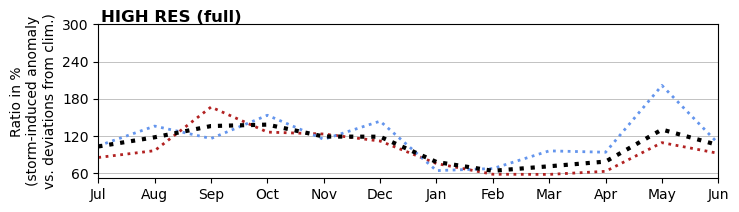

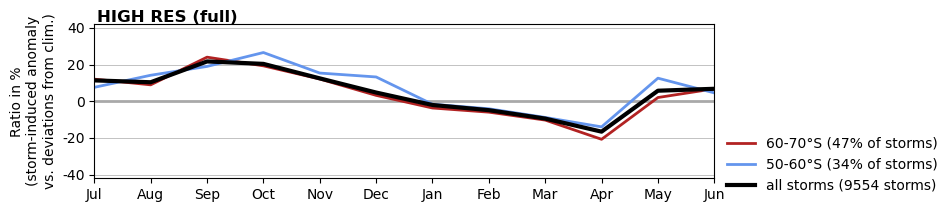

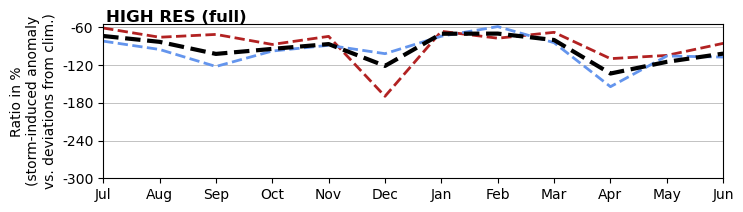

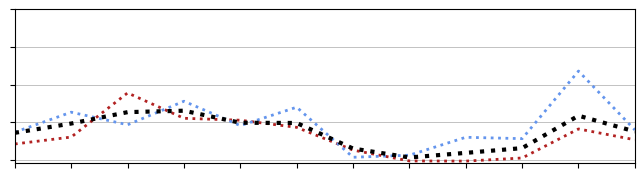

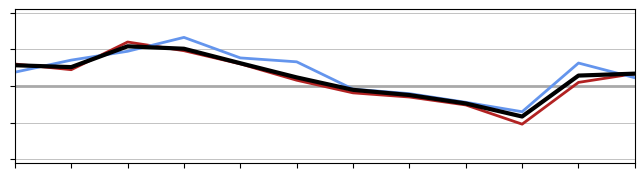

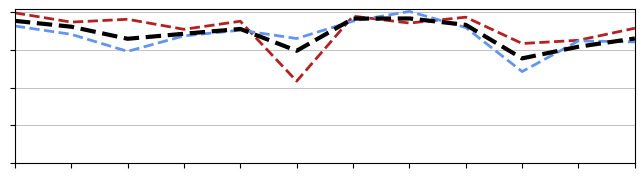

In [7]:
#----
# FOR PAPER
#----

w = 2
lw2 = 0.5
lw3 = 3
fs = 10
months = ['Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun']

color_list = ['firebrick','firebrick','cornflowerblue','cornflowerblue','k'] #plt.cm.Spectral(np.linspace(0,1,len(lat_bins))) #RdYlBu_r

ls = ['--','-',':']

which_one_to_plot = 'high_res_full'

if which_one_to_plot=='low_res_full':
    data_plot = np.copy(all_perc) # choose one here
    num_aux1  = np.copy(num_storms_all)
    num_aux2  = np.copy(num_storms_lat_bands)
    which_setup = 'LOW RES (full)' 
elif which_one_to_plot=='high_res_full':
    data_plot = np.copy(all_perc_hr) # choose one here
    num_aux1  = np.copy(num_storms_all_hr)
    num_aux2  = np.copy(num_storms_lat_bands_hr)
    which_setup = 'HIGH RES (full)' 
elif which_one_to_plot=='low_res_emulator':
    data_plot = np.copy(all_perc_em) # choose one here
    num_aux1  = np.copy(num_storms_all_em)
    num_aux2  = np.copy(num_storms_lat_bands_em)
    which_setup = 'LOW RES (emulator)' 

plot_eps = True

height_plot = 2
    
#----
# 75th/90th PERCENTILE
#----
ylim1,ylim2 = 52,300
lines = [60,120,180,240]
yticks = [60,120,180,240,300]
ytickslabels = [60,120,180,240,300]

# LOW RES (full)
fig = plt.figure(figsize=(8,height_plot))
plt.hlines(0,0,11,color='darkgrey',linewidth=lw)
for hh in lines:
    plt.hlines(hh,0,11,color='darkgrey',linewidth=lw2)
#plt.plot(reorder_months(all_perc[0,:,dd]),color='k',linewidth=lw,linestyle='--')
which_perc=2 #for which_perc in [0,1,2]:
for dd in [1,2,4]:#range(0,len(lat_bins)):
    if which_perc==1:
        if dd<len(lat_bins)-1:
            plt.plot(reorder_months(data_plot[which_perc,:,dd]),color=color_list[dd],linewidth=lw,linestyle=ls[which_perc],label=str(-1*lat_bins[dd+1])+\
                             '-'+str(-1*lat_bins[dd])+'°S ('+str(int(100*num_storms_lat_bands[dd]/num_storms_all))+'% of storms)')
        else:
            plt.plot(reorder_months(data_plot[which_perc,:,dd]),color=color_list[dd],linewidth=lw3,linestyle=ls[which_perc],\
                         label='all storms ('+str(int(num_storms_all))+' storms)')
    else:
        if dd<len(lat_bins)-1:
            plt.plot(reorder_months(data_plot[which_perc,:,dd]),color=color_list[dd],linewidth=lw,linestyle=ls[which_perc])
        else:
            plt.plot(reorder_months(data_plot[which_perc,:,dd]),color=color_list[dd],linewidth=lw3,linestyle=ls[which_perc])
plt.ylabel('Ratio in %\n(storm-induced anomaly\nvs. deviations from clim.)',fontsize=fs)
plt.xticks(np.arange(0,11+1,1),months,fontsize=fs)
plt.yticks(yticks,ytickslabels)
plt.xlim((0,11))
plt.ylim((ylim1,ylim2))
plt.annotate(which_setup,xy=(0.005,1.015),xycoords='axes fraction',fontsize=fs+2,ha='left',fontweight='bold') 
if save_plots:
    filename = 'Seasonal_cycle_FOR_PAPER_all_storms_vs_lat_bands_storm_anom_vs_deviations_from_clim_'+\
                    which_setup.replace(' ','_')+'_'+\
                    str(perc1)+'th_percentiles.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
if display_plots:
    plt.show()
else:
    plt.close(fig)
    
    
    
#----
# MEDIAN
#----
ylim1,ylim2 = -42,42
lines = [-40,-20,0,20,40]
yticks = [-40,-20,0,20,40]
ytickslabels = [-40,-20,0,20,40]

# LOW RES (full)
fig = plt.figure(figsize=(8,height_plot))
plt.hlines(0,0,11,color='darkgrey',linewidth=lw)
for hh in lines:
    plt.hlines(hh,0,11,color='darkgrey',linewidth=lw2)
#plt.plot(reorder_months(all_perc[0,:,dd]),color='k',linewidth=lw,linestyle='--')
which_perc=1 #for which_perc in [0,1,2]:
for dd in [1,2,4]:#range(0,len(lat_bins)):
    if which_perc==1:
        if dd<len(lat_bins)-1:
            plt.plot(reorder_months(data_plot[which_perc,:,dd]),color=color_list[dd],linewidth=lw,linestyle=ls[which_perc],label=str(-1*lat_bins[dd+1])+\
                             '-'+str(-1*lat_bins[dd])+'°S ('+str(int(100*num_aux2[dd]/num_storms_all))+'% of storms)')
        else:
            plt.plot(reorder_months(data_plot[which_perc,:,dd]),color=color_list[dd],linewidth=lw3,linestyle=ls[which_perc],\
                         label='all storms ('+str(int(num_aux1))+' storms)')
    else:
        if dd<len(lat_bins)-1:
            plt.plot(reorder_months(data_plot[which_perc,:,dd]),color=color_list[dd],linewidth=lw,linestyle=ls[which_perc])
        else:
            plt.plot(reorder_months(data_plot[which_perc,:,dd]),color=color_list[dd],linewidth=lw3,linestyle=ls[which_perc])
plt.ylabel('Ratio in %\n(storm-induced anomaly\nvs. deviations from clim.)',fontsize=fs)
plt.xticks(np.arange(0,11+1,1),months,fontsize=fs)
plt.yticks(yticks,ytickslabels)
plt.xlim((0,11))
plt.ylim((ylim1,ylim2))
plt.legend(loc='upper left',bbox_to_anchor=(1,0.35),frameon=False,\
               ncol=1,fancybox=False,shadow=False,prop={'size':10})
plt.annotate(which_setup,xy=(0.005,1.015),xycoords='axes fraction',fontsize=fs+2,ha='left',fontweight='bold') 
if save_plots:
    filename = 'Seasonal_cycle_FOR_PAPER_all_storms_vs_lat_bands_storm_anom_vs_deviations_from_clim_'+\
                    which_setup.replace(' ','_')+'_'+\
                    '50th_percentiles.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
if display_plots:
    plt.show()
else:
    plt.close(fig)
    

#----
# 25th/10th percentile
#----
ylim1,ylim2 = -300,-55
lines = [-240,-180,-120,-60]
yticks = [-300,-240,-180,-120,-60]
ytickslabels = [-300,-240,-180,-120,-60]

# LOW RES (full)
fig = plt.figure(figsize=(8,height_plot))
plt.hlines(0,0,11,color='darkgrey',linewidth=lw)
for hh in lines:
    plt.hlines(hh,0,11,color='darkgrey',linewidth=lw2)
#plt.plot(reorder_months(all_perc[0,:,dd]),color='k',linewidth=lw,linestyle='--')
which_perc=0 #for which_perc in [0,1,2]:
for dd in [1,2,4]:#range(0,len(lat_bins)):
    if which_perc==1:
        if dd<len(lat_bins)-1:
            plt.plot(reorder_months(data_plot[which_perc,:,dd]),color=color_list[dd],linewidth=lw,linestyle=ls[which_perc],label=str(-1*lat_bins[dd+1])+\
                             '-'+str(-1*lat_bins[dd])+'°S ('+str(int(100*num_storms_lat_bands[dd]/num_storms_all))+'% of storms)')
        else:
            plt.plot(reorder_months(data_plot[which_perc,:,dd]),color=color_list[dd],linewidth=lw3,linestyle=ls[which_perc],\
                         label='all storms ('+str(int(num_storms_all))+' storms)')
    else:
        if dd<len(lat_bins)-1:
            plt.plot(reorder_months(data_plot[which_perc,:,dd]),color=color_list[dd],linewidth=lw,linestyle=ls[which_perc])
        else:
            plt.plot(reorder_months(data_plot[which_perc,:,dd]),color=color_list[dd],linewidth=lw3,linestyle=ls[which_perc])
plt.ylabel('Ratio in %\n(storm-induced anomaly\nvs. deviations from clim.)',fontsize=fs)
plt.xticks(np.arange(0,11+1,1),months,fontsize=fs)
plt.yticks(yticks,ytickslabels)
plt.xlim((0,11))
plt.ylim((ylim1,ylim2))
plt.annotate(which_setup,xy=(0.005,1.015),xycoords='axes fraction',fontsize=fs+2,ha='left',fontweight='bold') 
if save_plots:
    filename = 'Seasonal_cycle_FOR_PAPER_all_storms_vs_lat_bands_storm_anom_vs_deviations_from_clim_'+\
                    which_setup.replace(' ','_')+'_'+\
                    str(perc2)+'th_percentiles.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
if display_plots:
    plt.show()
else:
    plt.close(fig)
    
if plot_eps:
    
    #----
    # 75th/90th PERCENTILE
    #----
    ylim1,ylim2 = 55,300
    lines = [60,120,180,240]
    yticks = [60,120,180,240,300]
    ytickslabels = [60,120,180,240,300]

    # LOW RES (full)
    fig = plt.figure(figsize=(8,height_plot))
    plt.hlines(0,0,11,color='darkgrey',linewidth=lw)
    for hh in lines:
        plt.hlines(hh,0,11,color='darkgrey',linewidth=lw2)
    #plt.plot(reorder_months(all_perc[0,:,dd]),color='k',linewidth=lw,linestyle='--')
    which_perc=2 #for which_perc in [0,1,2]:
    for dd in [1,2,4]:#range(0,len(lat_bins)):
        if which_perc==1:
            if dd<len(lat_bins)-1:
                plt.plot(reorder_months(data_plot[which_perc,:,dd]),color=color_list[dd],linewidth=lw,linestyle=ls[which_perc],label=str(-1*lat_bins[dd+1])+\
                                 '-'+str(-1*lat_bins[dd])+'°S ('+str(int(100*num_storms_lat_bands[dd]/num_storms_all))+'% of storms)')
            else:
                plt.plot(reorder_months(data_plot[which_perc,:,dd]),color=color_list[dd],linewidth=lw3,linestyle=ls[which_perc],\
                             label='all storms ('+str(int(num_storms_all))+' storms)')
        else:
            if dd<len(lat_bins)-1:
                plt.plot(reorder_months(data_plot[which_perc,:,dd]),color=color_list[dd],linewidth=lw,linestyle=ls[which_perc])
            else:
                plt.plot(reorder_months(data_plot[which_perc,:,dd]),color=color_list[dd],linewidth=lw3,linestyle=ls[which_perc])
    plt.xticks(np.arange(0,11+1,1),[],fontsize=fs)
    plt.yticks(yticks,[])
    plt.xlim((0,11))
    plt.ylim((ylim1,ylim2))
    if save_plots:
        filename = 'Seasonal_cycle_FOR_PAPER_all_storms_vs_lat_bands_storm_anom_vs_deviations_from_clim_'+\
                        which_setup.replace(' ','_').replace('(','').replace(')','')+'_'+\
                        str(perc1)+'th_percentiles.eps'
        plt.savefig(savepath2+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)



    #----
    # MEDIAN
    #----
    ylim1,ylim2 = -42,42
    lines = [-40,-20,0,20,40]
    yticks = [-40,-20,0,20,40]
    ytickslabels = [-40,-20,0,20,40]

    # LOW RES (full)
    fig = plt.figure(figsize=(8,height_plot))
    plt.hlines(0,0,11,color='darkgrey',linewidth=lw)
    for hh in lines:
        plt.hlines(hh,0,11,color='darkgrey',linewidth=lw2)
    #plt.plot(reorder_months(all_perc[0,:,dd]),color='k',linewidth=lw,linestyle='--')
    which_perc=1 #for which_perc in [0,1,2]:
    for dd in [1,2,4]:#range(0,len(lat_bins)):
        if which_perc==1:
            if dd<len(lat_bins)-1:
                plt.plot(reorder_months(data_plot[which_perc,:,dd]),color=color_list[dd],linewidth=lw,linestyle=ls[which_perc],label=str(-1*lat_bins[dd+1])+\
                                 '-'+str(-1*lat_bins[dd])+'°S ('+str(int(100*num_aux2[dd]/num_storms_all))+'% of storms)')
            else:
                plt.plot(reorder_months(data_plot[which_perc,:,dd]),color=color_list[dd],linewidth=lw3,linestyle=ls[which_perc],\
                             label='all storms ('+str(int(num_aux1))+' storms)')
        else:
            if dd<len(lat_bins)-1:
                plt.plot(reorder_months(data_plot[which_perc,:,dd]),color=color_list[dd],linewidth=lw,linestyle=ls[which_perc])
            else:
                plt.plot(reorder_months(data_plot[which_perc,:,dd]),color=color_list[dd],linewidth=lw3,linestyle=ls[which_perc])
    plt.xticks(np.arange(0,11+1,1),[],fontsize=fs)
    plt.yticks(yticks,[])
    plt.xlim((0,11))
    plt.ylim((ylim1,ylim2))
    if save_plots:
        filename = 'Seasonal_cycle_FOR_PAPER_all_storms_vs_lat_bands_storm_anom_vs_deviations_from_clim_'+\
                        which_setup.replace(' ','_').replace('(','').replace(')','')+'_'+\
                        '50th_percentiles.eps'
        plt.savefig(savepath2+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)


    #----
    # 25th/10th percentile
    #----
    ylim1,ylim2 = -300,-55
    lines = [-240,-180,-120,-60]
    yticks = [-300,-240,-180,-120,-60]
    ytickslabels = [-300,-240,-180,-120,-60]

    # LOW RES (full)
    fig = plt.figure(figsize=(8,height_plot))
    plt.hlines(0,0,11,color='darkgrey',linewidth=lw)
    for hh in lines:
        plt.hlines(hh,0,11,color='darkgrey',linewidth=lw2)
    #plt.plot(reorder_months(all_perc[0,:,dd]),color='k',linewidth=lw,linestyle='--')
    which_perc=0 #for which_perc in [0,1,2]:
    for dd in [1,2,4]:#range(0,len(lat_bins)):
        if which_perc==1:
            if dd<len(lat_bins)-1:
                plt.plot(reorder_months(data_plot[which_perc,:,dd]),color=color_list[dd],linewidth=lw,linestyle=ls[which_perc],label=str(-1*lat_bins[dd+1])+\
                                 '-'+str(-1*lat_bins[dd])+'°S ('+str(int(100*num_storms_lat_bands[dd]/num_storms_all))+'% of storms)')
            else:
                plt.plot(reorder_months(data_plot[which_perc,:,dd]),color=color_list[dd],linewidth=lw3,linestyle=ls[which_perc],\
                             label='all storms ('+str(int(num_storms_all))+' storms)')
        else:
            if dd<len(lat_bins)-1:
                plt.plot(reorder_months(data_plot[which_perc,:,dd]),color=color_list[dd],linewidth=lw,linestyle=ls[which_perc])
            else:
                plt.plot(reorder_months(data_plot[which_perc,:,dd]),color=color_list[dd],linewidth=lw3,linestyle=ls[which_perc])
    plt.xticks(np.arange(0,11+1,1),[],fontsize=fs)
    plt.yticks(yticks,[])
    plt.xlim((0,11))
    plt.ylim((ylim1,ylim2))
    if save_plots:
        filename = 'Seasonal_cycle_FOR_PAPER_all_storms_vs_lat_bands_storm_anom_vs_deviations_from_clim_'+\
                        which_setup.replace(' ','_').replace('(','').replace(')','')+'_'+\
                        str(perc2)+'th_percentiles.eps'
        plt.savefig(savepath2+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)


/tmp/ipykernel_54578/3222725714.py:12: RuntimeWarning: Mean of empty slice
  ratio_em[tt] = 100*np.nanmean(data_storm_em[tt,:,:])/np.nanmean(data_dev_em[tt,:,:])


9554.0 [717. 712. 776. 836. 897. 868. 888. 872. 788. 802. 693. 705.]
7833.0 [696. 698. 774. 753. 554. 415. 488. 643. 734. 755. 653. 670.]


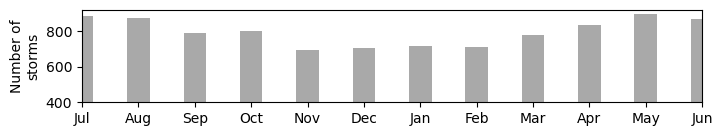

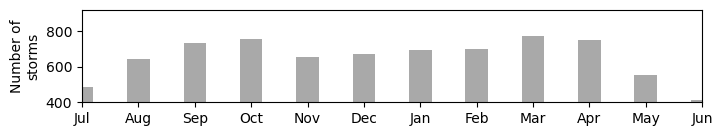

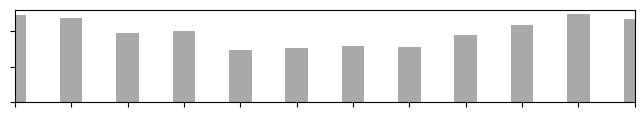

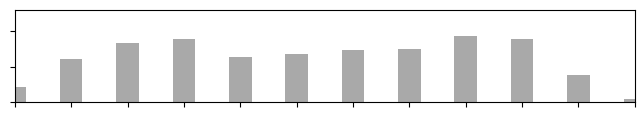

In [8]:
#----
# make bar plot of number of storms per month
#----
# Note: the storms for LOW RES and HIGH RES full field are the same!

ratio    = np.zeros([num_storms])
if plot_hr:
    ratio_hr = np.zeros([num_storms])
ratio_em = np.zeros([num_storms])
for tt in range(0,num_storms):
    ratio[tt]    = 100*np.nanmean(data_storm[tt,:,:])/np.nanmean(data_dev[tt,:,:])
    ratio_em[tt] = 100*np.nanmean(data_storm_em[tt,:,:])/np.nanmean(data_dev_em[tt,:,:])
    if plot_hr:
        ratio_hr[tt] = 100*np.nanmean(data_storm_hr[tt,:,:])/np.nanmean(data_dev_hr[tt,:,:])
    
ind_no_NaN    = np.where(~np.isnan(ratio))[0]
ind_no_NaN_em = np.where(~np.isnan(ratio_em))[0]

num_storms_per_month    = np.zeros([12])
num_storms_per_month_em = np.zeros([12])
for mm in range(0,12):
    ind    = np.where(month_storm==mm+1)[0]
    ind_em = np.where(month_storm_em[ind_no_NaN_em]==mm+1)[0]
    num_storms_per_month[mm]    = ind.shape[0]
    num_storms_per_month_em[mm] = ind_em.shape[0]
    del ind,ind_em

print(np.sum(num_storms_per_month),num_storms_per_month)
print(np.sum(num_storms_per_month_em),num_storms_per_month_em)

w1    = 0.4
y1,y2 = 400,920 
hh    = 1.2

fig = plt.figure(figsize=(8,hh))
plt.bar(np.arange(0,11+1,1),reorder_months(num_storms_per_month),color='darkgrey',width=w1)
plt.xticks(np.arange(0,11+1,1),months,fontsize=fs)
plt.yticks([400,600,800],[400,600,800])
plt.ylabel('Number of\nstorms')
plt.ylim((y1,y2))
plt.xlim((0,11))
if save_plots:
    filename = 'Number_of_storms_bar_plot_LOW_RES_HIGH_RES_full_field.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
if display_plots:
    plt.show()
else:
    plt.close(fig)

fig = plt.figure(figsize=(8,hh))
plt.bar(np.arange(0,11+1,1),reorder_months(num_storms_per_month_em),color='darkgrey',width=w1)
plt.xticks(np.arange(0,11+1,1),months,fontsize=fs)
plt.yticks([400,600,800],[400,600,800])
plt.ylabel('Number of\nstorms')
plt.ylim((y1,y2))
plt.xlim((0,11))
if save_plots:
    filename = 'Number_of_storms_bar_plot_LOW_RES_emulator.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
if display_plots:
    plt.show()
else:
    plt.close(fig)

if plot_eps:
    fig = plt.figure(figsize=(8,hh))
    #plt.hlines(600,0,11,color='darkgrey',linewidth=lw)
    #plt.hlines(800,0,11,color='darkgrey',linewidth=lw)
    plt.bar(np.arange(0,11+1,1),reorder_months(num_storms_per_month),color='darkgrey',width=w1)
    plt.xticks(np.arange(0,11+1,1),[],fontsize=fs)
    plt.yticks([400,600,800],[])
    plt.ylim((y1,y2))
    plt.xlim((0,11))
    if save_plots:
        filename = 'Number_of_storms_bar_plot_LOW_RES_HIGH_RES_full_field.eps'
        plt.savefig(savepath2+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)

    fig = plt.figure(figsize=(8,hh))
    #plt.hlines(600,0,11,color='darkgrey',linewidth=lw)
    #plt.hlines(800,0,11,color='darkgrey',linewidth=lw)
    plt.bar(np.arange(0,11+1,1),reorder_months(num_storms_per_month_em),color='darkgrey',width=w1)
    plt.xticks(np.arange(0,11+1,1),[],fontsize=fs)
    plt.yticks([400,600,800],[])
    plt.ylim((y1,y2))
    plt.xlim((0,11))
    if save_plots:
        filename = 'Number_of_storms_bar_plot_LOW_RES_emulator.eps'
        plt.savefig(savepath2+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)
    
    

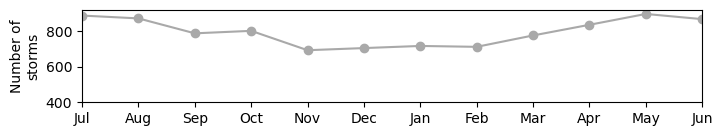

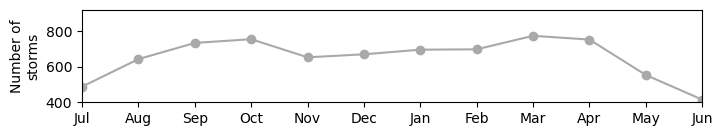

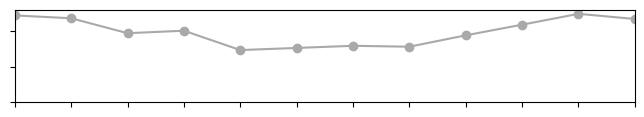

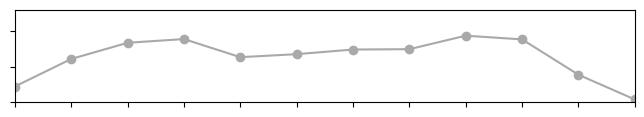

In [9]:

fig = plt.figure(figsize=(8,hh))
plt.plot(np.arange(0,11+1,1),reorder_months(num_storms_per_month),'-',color='darkgrey')
plt.plot(np.arange(0,11+1,1),reorder_months(num_storms_per_month),'o',color='darkgrey')
plt.xticks(np.arange(0,11+1,1),months,fontsize=fs)
plt.yticks([400,600,800],[400,600,800])
plt.ylabel('Number of\nstorms')
plt.ylim((y1,y2))
plt.xlim((0,11))
if save_plots:
    filename = 'Number_of_storms_LOW_RES_HIGH_RES_full_field.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
if display_plots:
    plt.show()
else:
    plt.close(fig)

fig = plt.figure(figsize=(8,hh))
plt.plot(np.arange(0,11+1,1),reorder_months(num_storms_per_month_em),'-',color='darkgrey')
plt.plot(np.arange(0,11+1,1),reorder_months(num_storms_per_month_em),'o',color='darkgrey')
plt.xticks(np.arange(0,11+1,1),months,fontsize=fs)
plt.yticks([400,600,800],[400,600,800])
plt.ylabel('Number of\nstorms')
plt.ylim((y1,y2))
plt.xlim((0,11))
if save_plots:
    filename = 'Number_of_storms_LOW_RES_emulator.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
if display_plots:
    plt.show()
else:
    plt.close(fig)
    
if plot_eps:
    fig = plt.figure(figsize=(8,hh))
    #plt.hlines(600,0,11,color='darkgrey',linewidth=lw)
    #plt.hlines(800,0,11,color='darkgrey',linewidth=lw)
    plt.plot(np.arange(0,11+1,1),reorder_months(num_storms_per_month),'-',color='darkgrey')
    plt.plot(np.arange(0,11+1,1),reorder_months(num_storms_per_month),'o',color='darkgrey')
    plt.xticks(np.arange(0,11+1,1),[],fontsize=fs)
    plt.yticks([400,600,800],[])
    plt.ylim((y1,y2))
    plt.xlim((0,11))
    if save_plots:
        filename = 'Number_of_storms_LOW_RES_HIGH_RES_full_field.eps'
        plt.savefig(savepath2+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)

    fig = plt.figure(figsize=(8,hh))
    #plt.hlines(600,0,11,color='darkgrey',linewidth=lw)
    #plt.hlines(800,0,11,color='darkgrey',linewidth=lw)
    plt.plot(np.arange(0,11+1,1),reorder_months(num_storms_per_month_em),'-',color='darkgrey')
    plt.plot(np.arange(0,11+1,1),reorder_months(num_storms_per_month_em),'o',color='darkgrey')
    plt.xticks(np.arange(0,11+1,1),[],fontsize=fs)
    plt.yticks([400,600,800],[])
    plt.ylim((y1,y2))
    plt.xlim((0,11))
    if save_plots:
        filename = 'Number_of_storms_LOW_RES_emulator.eps'
        plt.savefig(savepath2+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)
        